Name: Matthew Shedden

ID: 202068657

CS983: Evolutionary Computation for Finance I

# Week 2, Assignment (Portfolio Optimization problem)
1. Select 10 stocks, from various sectors.
2. Using GA, identify optimal portfolio weights, given risk and return. (8/20)
3. Then, test the 'portfolio'...
- ...against future data (e.g. 2020). (4/20)
- ...against randomly weighted portfolios. (4/20)
4. Evaluate portfolios with different balances of risk/reward. (4/20)

In [1]:
# load packages
library(quantmod)
library(GA)
library(dplyr)

Warning message:
"package 'quantmod' was built under R version 3.6.3"Loading required package: xts
Warning message:
"package 'xts' was built under R version 3.6.3"Loading required package: zoo
Warning message:
"package 'zoo' was built under R version 3.6.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: TTR
Warning message:
"package 'TTR' was built under R version 3.6.3"Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
"package 'GA' was built under R version 3.6.3"Loading required package: foreach
Warning message:
"package 'foreach' was built under R version 3.6.3"Loading required package: iterators
Warning message:
"package 'iterators' was built under R version 3.6.3"Package 'GA' version 3.2
Type 'citation("GA")' for citing this R package in publications.

Attaching package: 'GA'

The following object is masked from 'package:utils':

## Select 10 stocks, from various sectors.
To select a good variety of stocks, I chose to select based on:
- Exchange: NYSE and NASDAQ, since data is plentiful.
- Sector: I selected 1 stock per 10/11 GICS sectors (excluding real estate) [www.msci.com/gics]
- Size: 5 stocks >= 10B ("large / mega cap"); 2B < 10B ("mid cap")
Method: www.finance.yahoo.com/screener

Chosen stocks were:

| Sector | Size | Company | Ticker |
| --- | --- | --- | --- |
| Basic Materials | Large / Mega | Barrick Gold | GOLD |
| Financial Services | Large / Mega | JP Morgan | JPM |
| Healthcare | Large / Mega | Bristol-Myers Squibb | BMY |
| Communication Services | Large / Mega | Verizon | VZ |
| Industrials | Large / Mega | MMM | MMM |
| Consumer Cyclical | Mid | Under Armor | UA |
| Consumer Defensive | Mid | COTY | COTY |
| Utilities | Mid | Enel Chile | ENIC |
| Energy | Mid | Marathon Oil | MRO |
| Technology | Mid | Dolby Laboratories | DLB |

In [2]:
# Retrieving data
myStocks <- c("GOLD","JPM","BMY","VZ","MMM","UA","COTY","ENIC","MRO","DLB")
getSymbols(myStocks, src="yahoo", from="2018-01-01", to="2019-01-01")

'getSymbols' currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
'loadSymbols' to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.

pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols


[1] "GOLD" "JPM"  "BMY"  "VZ"   "MMM"  "UA"   "COTY" "ENIC" "MRO"  "DLB"

In [3]:
# Calculate daily returns, renaming columns
RetData2018 <- data.frame(as.xts(merge(dailyReturn(GOLD), dailyReturn(JPM), dailyReturn(BMY),
                                       dailyReturn(VZ), dailyReturn(MMM), dailyReturn(UA),
                                       dailyReturn(COTY), dailyReturn(ENIC), dailyReturn(MRO), dailyReturn(DLB))))
colnames(RetData2018) <- myStocks
# Calculate mean daily returns
MeanReturn2018 <- apply(RetData2018, MARGIN = 2, FUN = mean)
# Calculate daily portfolio covariance
Covariance2018 <- cov(RetData2018)

## 1. Using GA, identify optimal portfolio weights, given risk and return.

In [4]:
# Defining an initial 'random' weight
wt <- runif(n=length(myStocks))
# Defining the fitness function
OptimalWeight2018 <- function(wt){
  wt <- wt / sum(wt)                              # weight
  Return <- (sum(wt * MeanReturn2018)+1)^252-1    # returns
  Risk <- sqrt(t(wt) %*% (Covariance2018 %*% wt)) # risk
  Optimal <- Return / Risk                        # combination ('Sharpe ratio')
  return(Optimal)
}

The optimal weighting of the 2018 portfolio is:
           GOLD        JPM         BMY        VZ        MMM        UA
[1,] 0.03697057 0.01184961 0.007240047 0.4372726 0.01161083 0.4594124
            COTY       ENIC         MRO        DLB
[1,] 0.001762522 0.01025108 0.005976546 0.01765382


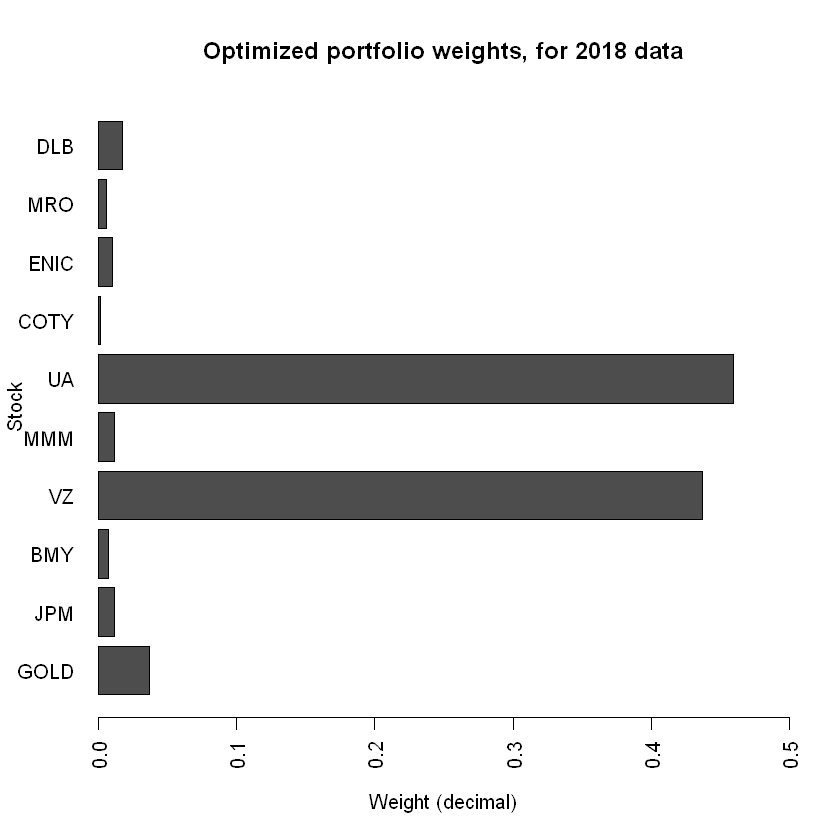

In [49]:
# Building genetic algorithm
Optimizer2018 <- ga(type = "real-valued", fitness = OptimalWeight2018,
                    lower = rep(x = 0,times = length(myStocks)),
                    upper = rep(x = 1,times = length(myStocks)), maxiter = 1000, names = myStocks)
Optimizer2018@solution <- Optimizer2018@solution / sum(Optimizer2018@solution)
cat("The optimal weighting of the 2018 portfolio is:\n")
colnames(Optimizer2018@solution) <- myStocks
print(Optimizer2018@solution)
barplot(Optimizer2018@solution, xlab = "Weight (decimal)", ylab = "Stock",
        main = "Optimized portfolio weights, for 2018 data", horiz = T, xlim = c(0,.5), las = 2)

## 2. Test the 'portfolio'... against future data
My take: To test the '2018 portfolio' against new data (2019 returns and risk), a new GA shall be first created. Then, 'weights' shall be compared; and the variation in returns and risk as weights change.

"To do this you will need to keep back some of your data (like a standard train/test split). For example, you might have trained your portfolio using data from 2019 to give you a set of weights. Then, keeping these weights constant, use them to calculate the returns from 2020  data. This should be a very simple calculation."

In [6]:
# Get stocks data for 2019
getSymbols(myStocks, src="yahoo", from="2019-01-01", to="2020-01-01")
RetData2019 <- data.frame(as.xts(merge(dailyReturn(GOLD), dailyReturn(JPM), dailyReturn(BMY),
                                       dailyReturn(VZ), dailyReturn(MMM), dailyReturn(UA),
                                       dailyReturn(COTY), dailyReturn(ENIC), dailyReturn(MRO), dailyReturn(DLB))))
colnames(RetData2019) <- myStocks
# Calculate mean daily returns
MeanReturn2019 <- apply(RetData2019, MARGIN = 2, FUN = mean)
# Calculate daily portfolio covariance
Covariance2019 <- cov(RetData2018)

pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols


[1] "GOLD" "JPM"  "BMY"  "VZ"   "MMM"  "UA"   "COTY" "ENIC" "MRO"  "DLB"

In [7]:
# Defining the fitness function
OptimalWeight2019 <- function(wt){
  wt <- wt / sum(wt)
  Return <- (sum(wt * MeanReturn2019)+1)^252-1
  Risk <- sqrt(t(wt) %*% (Covariance2019 %*% wt))
  Optimal <- Return / Risk
  return(Optimal)
}
# Genetic Algorithm
Optimizer2019 <- ga(type = "real-valued", fitness = OptimalWeight2019,
                    lower = rep(x = 0,times = length(myStocks)),
                    upper = rep(x = 1,times = length(myStocks)), maxiter = 1000,names = myStocks)
Optimizer2019@solution <- Optimizer2019@solution / sum(Optimizer2019@solution)

In [119]:
# 2018 vs. 2019 returns for the optimised portfolio
cat("In 2018, the optimised '2018' portfolio generates returns of: ",
    round(((sum(Optimizer2018@solution * MeanReturn2018)+1)^252-1)*100,digits = 2),"%")
cat("\nIn 2019, the optimised '2018' portfolio generates returns of: ",
    round(((sum(Optimizer2018@solution * MeanReturn2019)+1)^252-1)*100,digits = 2),"%")
cat("\n\nThis is curious. Let's evaluate the optimised '2018' portfolio against an optimised '2019' portfolio.")
# Comparing 2019 returns for the optimised portfolio against a new '2019' optimised portfolio
cat("\n\nThe returns provided by the '2018 portfolio' is: ",
    round(((sum(Optimizer2018@solution * MeanReturn2019)+1)^252-1)*100,digits = 2),"%")
cat("\nThe returns provided by the '2019 portfolio' is: ",
    round(((sum(Optimizer2019@solution * MeanReturn2019)+1)^252-1)*100,digits = 2),"%")
cat("\n\nThe optimised '2018' portfolio performs well. Yet, this is far from the optimal portfolio for 2019 (test) data.")

In 2018, the optimised '2018' portfolio generates returns of:  18.69 %
In 2019, the optimised '2018' portfolio generates returns of:  21.04 %

This is curious. Let's evaluate the optimised '2018' portfolio against an optimised '2019' portfolio.

The returns provided by the '2018 portfolio' is:  21.04 %
The returns provided by the '2019 portfolio' is:  54.21 %

The optimised '2018' portfolio performs well. Yet, this is far from the optimal portfolio for 2019 (test) data.

The weighting for the '2018 portfolio' was:
           GOLD        JPM         BMY        VZ        MMM        UA
[1,] 0.03697057 0.01184961 0.007240047 0.4372726 0.01161083 0.4594124
            COTY       ENIC         MRO        DLB
[1,] 0.001762522 0.01025108 0.005976546 0.01765382

The weighting for the '2019 portfolio' was:
          GOLD       JPM        BMY          VZ         MMM         UA
[1,] 0.2212488 0.4531979 0.03911525 0.005524128 0.003001624 0.01083048
          COTY       ENIC         MRO       DLB
[1,] 0.2328452 0.01726432 0.004156274 0.0128161


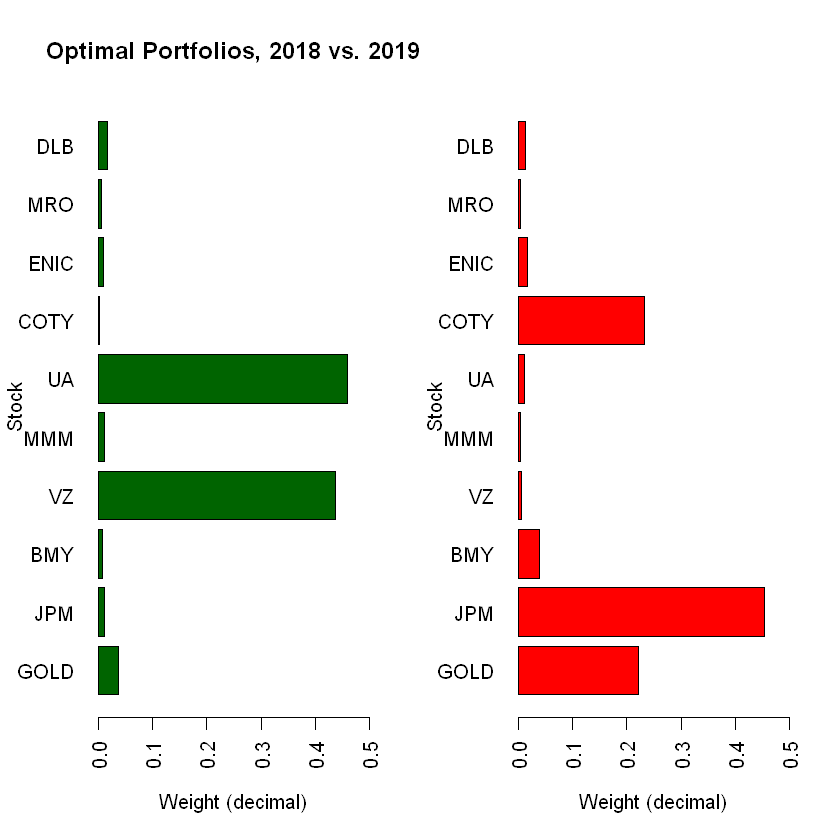

In [59]:
# comparing weights
cat("The weighting for the '2018 portfolio' was:\n")
print(Optimizer2018@solution)
colnames(Optimizer2019@solution) <- myStocks
cat("\nThe weighting for the '2019 portfolio' was:\n")
print(Optimizer2019@solution)

par(mfrow = c(1,2))

barplot(Optimizer2018@solution,col="darkgreen", horiz = T, xlim = c(0,.5), las = 2,
        xlab = "Weight (decimal)", ylab = "Stock", main="Optimal Portfolios, 2018 vs. 2019") 
barplot(Optimizer2019@solution,col="red", horiz = T, xlim = c(0,.5), las = 2,
        xlab = "Weight (decimal)", ylab = "Stock")

Demonstrated by differences in weights and resultant returns, significant changes to the optimised '2018' portfolio need to be made, if it is to achieve optimal performance in 2019.

## 3. Comparison of the evolved portfolio with balanced and random portfolios

"Is the portfolio you evolved any good?  Compare the performance against an evenly balanced portfolio and the average of several runs of randomly generated portfolios. You could use run this comparison on both the training and the test data."

In [10]:
weight_equal <- rep(x = 0.1,times = length(myStocks)) # equally weighted portfolio
weight_rand1 <- runif(n=length(myStocks)) 
weight_rand1 <- weight_rand1 / sum(weight_rand1)      # randomly weighted portfolio (1)
weight_rand2 <- runif(n=length(myStocks)) 
weight_rand2 <- weight_rand2 / sum(weight_rand2)      # randomly weighted portfolio (2)

cat("The evolved portfolio, for the 2018 (train) set, gives a return portfolio return of: ",
    round(((sum(Optimizer2018@solution * MeanReturn2018)+1)^252-1)*100,digits = 2),"%",
    "\nThe evolved portfolio, for the 2019 (test) set, gives a return portfolio return of: ",
    round(((sum(Optimizer2018@solution * MeanReturn2019)+1)^252-1)*100,digits = 2),"%",
    "\n\nThe equally weighted portfolio, for the 2018 (train) set, gives a return portfolio return of: ",
    round(((sum(weight_equal * MeanReturn2018)+1)^252-1)*100,digits = 2),"%",
    "\nThe equally weighted portfolio, for the 2019 (test) set, gives a return portfolio return of: ",
    round(((sum(weight_equal * MeanReturn2019)+1)^252-1)*100,digits = 2),"%",
    "\n\nThe 1st randomly weighted portfolio, for the 2018 (train) set, gives a return portfolio return of: ",
    round(((sum(weight_rand1 * MeanReturn2018)+1)^252-1)*100,digits = 2),"%",
    "\nThe 1st randomly weighted portfolio, for the 2019 (test) set, gives a return portfolio return of: ",
    round(((sum(weight_rand1 * MeanReturn2019)+1)^252-1)*100,digits = 2),"%",
    "\n\nThe 2nd randomly weighted portfolio, for the 2018 (train) set, gives a return portfolio return of: ",
    round(((sum(weight_rand2 * MeanReturn2018)+1)^252-1)*100,digits = 2),"%",
    "\nThe 2nd randomly weighted portfolio, for the 2019 (test) set, gives a return portfolio return of: ",
    round(((sum(weight_rand2 * MeanReturn2019)+1)^252-1)*100,digits = 2),"%")

The evolved portfolio, for the 2018 (train) set, gives a return portfolio return of:  18.42 % 
The evolved portfolio, for the 2019 (test) set, gives a return portfolio return of:  20.3 % 

The equally weighted portfolio, for the 2018 (train) set, gives a return portfolio return of:  -11.45 % 
The equally weighted portfolio, for the 2019 (test) set, gives a return portfolio return of:  25.39 % 

The 1st randomly weighted portfolio, for the 2018 (train) set, gives a return portfolio return of:  -17.81 % 
The 1st randomly weighted portfolio, for the 2019 (test) set, gives a return portfolio return of:  26.01 % 

The 2nd randomly weighted portfolio, for the 2018 (train) set, gives a return portfolio return of:  -6.2 % 
The 2nd randomly weighted portfolio, for the 2019 (test) set, gives a return portfolio return of:  20.33 %

Evaluating the performance of these random portfolios, the Optimised 2018 Portfolio actually performs the worst of all portfolios on the test (2019) dataset!

(makes one wonder the robustness of Markowitz portfolio optimisation, in practice)

## 4. Creation and evaluation of portfolios with differently balanced risk and return (to emulate a multi-objective approach)
Within your fitness function your risk and return values will be evenly balanced. You can modify this to create differently balanced portfolios - e.g. at the extremes might be ones which only care about maximising returns or are very risk averse, and in between might be ones which prioritise risk over return and vice-versa. How do the weights and the performance of these portfolios compare?

In [125]:
# 1. Maximum return
MaximumReturn <- function(wt){
  wt <- wt / sum(wt)                                  # weight
  Return2018 <- (sum(wt * MeanReturn2018)+1)^252-1    # returns
  return(Return2018)
}
MaximumReturnOptimizer <- ga(type = "real-valued", fitness = MaximumReturn,
                             lower = rep(x = 0,times = length(myStocks)),
                             upper = rep(x = 1,times = length(myStocks)), maxiter = 1000, names = myStocks, monitor = F)
MaximumReturnOptimizer@solution <- MaximumReturnOptimizer@solution / sum(MaximumReturnOptimizer@solution)
colnames(MaximumReturnOptimizer@solution) <- myStocks
cat("The weighting of the 'Maximum Return' portfolio is: ", MaximumReturnOptimizer@solution)

The weighting of the 'Maximum Return' portfolio is:  0.01327349 0.007178881 0.009764795 0.04512369 0.02953916 0.8361754 0.007162824 0.008290152 0.009284451 0.03420717

In [124]:
# 2. Minimum risk
MinimumRisk <- function(wt){
  wt <- wt / sum(wt)                                  # weight
  Risk2018 <- sqrt(t(wt) %*% (Covariance2018 %*% wt)) # risk
  return(-Risk2018)                                   # '-' required for minimization problem
}
MinimumRiskOptimizer <- ga(type = "real-valued", fitness = MinimumRisk,
                           lower = rep(x = 0,times = length(myStocks)),
                           upper = rep(x = 1,times = length(myStocks)), maxiter = 1000, names = myStocks, monitor = F)
MinimumRiskOptimizer@solution <- MinimumRiskOptimizer@solution / sum(MinimumRiskOptimizer@solution)
colnames(MinimumRiskOptimizer@solution) <- myStocks
cat("The optimal weighting of the 'Minimum Risk' portfolio is: ", MinimumRiskOptimizer@solution)

The optimal weighting of the 'Minimum Risk' portfolio is:  0.1692915 0.143871 0.1067161 0.2756601 0.01401276 0.001441472 0.04218623 0.1017958 0.001308653 0.1437163

In [121]:
# 3. 'Adventurous' (75:25 weighting)
Adventurous <- function(wt){
  wt <- wt / sum(wt)                                                    # weight
  Return2018 <- (sum((wt*(75/25)) * MeanReturn2018)+1)^252-1            # greater returns
  Risk2018 <- sqrt(t(wt*(75/25)) %*% (Covariance2018 %*% (wt*(75/25)))) # greater risk
  Optimal2018 <- (Return2018 / Risk2018)                                # combination ('Sharpe ratio')
  return(Optimal2018)
}
AdventurousOptimizer <- ga(type = "real-valued", fitness = Adventurous,
                           lower = rep(x = 0,times = length(myStocks)),
                           upper = rep(x = 1,times = length(myStocks)), maxiter = 1000, names = myStocks, monitor = F)
AdventurousOptimizer@solution <- AdventurousOptimizer@solution / sum(AdventurousOptimizer@solution)
colnames(AdventurousOptimizer@solution) <- myStocks
cat("The optimal weighting of the 'Adventurous' portfolio is: ", AdventurousOptimizer@solution)

The optimal weighting of the 'Adventurous' portfolio is:  0.02334463 0.02744123 0.01431099 0.220096 0.003832616 0.649129 0.005393173 0.006938833 0.01384078 0.03567273

In [122]:
# 4. 'Cautious' (25:75 weighting)
Cautious <- function(wt){
  wt <- wt / sum(wt)                                                    # weight
  Return2018 <- (sum((wt*(25/75)) * MeanReturn2018)+1)^252-1            # less returns
  Risk2018 <- sqrt(t(wt*(25/75)) %*% (Covariance2018 %*% (wt*(25/75)))) # less risk
  Optimal2018 <- (Return2018 / Risk2018)                                # combination ('Sharpe ratio')
  return(Optimal2018)
}
CautiousOptimizer <- ga(type = "real-valued", fitness = Cautious,
                        lower = rep(x = 0,times = length(myStocks)), 
                        upper = rep(x = 1,times = length(myStocks)), maxiter = 1000, names = myStocks, monitor = F)
CautiousOptimizer@solution <- CautiousOptimizer@solution / sum(CautiousOptimizer@solution)
colnames(CautiousOptimizer@solution) <- myStocks
cat("The optimal weighting of the 'Cautious' portfolio is: ", CautiousOptimizer@solution)

The optimal weighting of the 'Cautious' portfolio is:  0.04140823 0.0119621 0.01340881 0.4487791 0.009315181 0.4448145 0.001187838 0.005189096 0.01074108 0.01319407

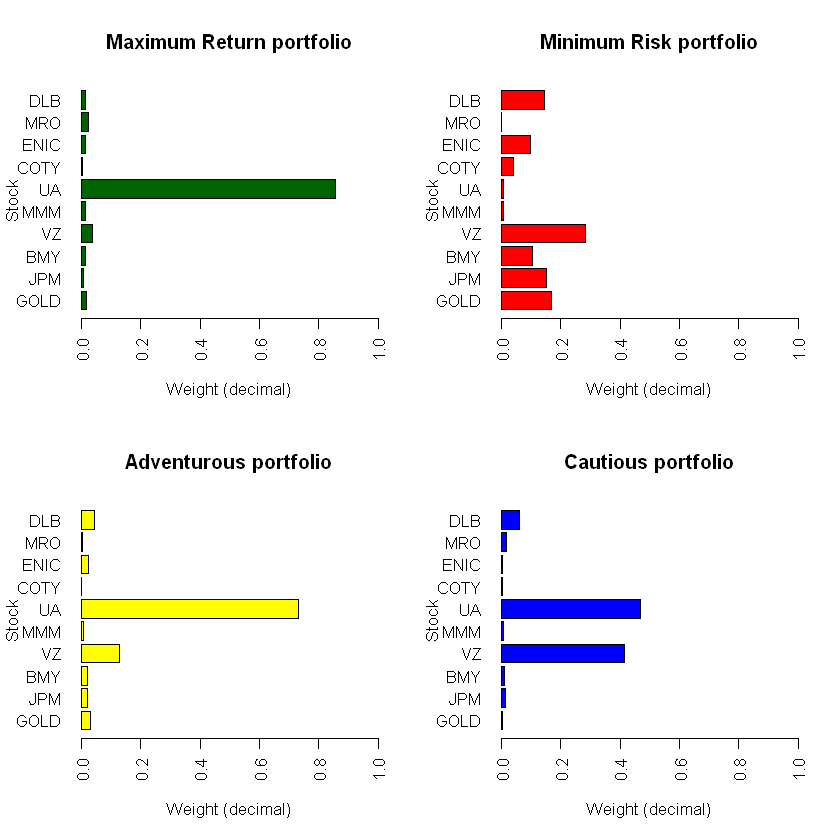

In [117]:
par(mfrow = c(2,2))

barplot(MaximumReturnOptimizer@solution,col="darkgreen", horiz = T, xlim = c(0,1), las = 2,
        xlab = "Weight (decimal)", ylab = "Stock", main="Maximum Return portfolio") 
barplot(MinimumRiskOptimizer@solution,col="red", horiz = T, xlim = c(0,1), las = 2, 
        xlab = "Weight (decimal)", ylab = "Stock", main="Minimum Risk portfolio")
barplot(AdventurousOptimizer@solution,col="yellow", horiz = T, xlim = c(0,1), las = 2,
        xlab = "Weight (decimal)", ylab = "Stock", main="Adventurous portfolio") 
barplot(CautiousOptimizer@solution,col="blue", horiz = T, xlim = c(0,1), las = 2,
        xlab = "Weight (decimal)", ylab = "Stock", main="Cautious portfolio")

In [123]:
cat("The 'Maximum Return' portfolio, for the 2018 (train) set, gives a return of: ",
    round(((sum(MaximumReturnOptimizer@solution * MeanReturn2018)+1)^252-1)*100,digits = 2),"%",
    "\nThe 'Maximum Return' portfolio, for the 2018 (train) set, gives a st.dev of: ",
    round(sqrt(t(as.numeric(MaximumReturnOptimizer@solution[1,])) %*%
               (Covariance2018 %*% as.numeric(MaximumReturnOptimizer@solution[1,]))),2),
    "\n\nThe 'Minimum Risk' portfolio, for the 2018 (train) set, gives a return of: ",
    round(((sum(MinimumRiskOptimizer@solution * MeanReturn2018)+1)^252-1)*100,digits = 2),"%",
    "\nThe 'Minimum Risk' portfolio, for the 2018 (train) set, gives a st.dev of: ",
    round(sqrt(t(as.numeric(MinimumRiskOptimizer@solution[1,])) %*%
               (Covariance2018 %*% as.numeric(MinimumRiskOptimizer@solution[1,]))),2),
    "\n\nThe 'Adventurous' portfolio, for the 2018 (train) set, gives a return of: ",
    round(((sum(AdventurousOptimizer@solution * MeanReturn2018)+1)^252-1)*100,digits = 2),"%",
    "\nThe 'Adventurous' portfolio, for the 2018 (train) set, gives a st.dev of: ",
    round(sqrt(t(as.numeric(AdventurousOptimizer@solution[1,])) %*%
               (Covariance2018 %*% as.numeric(AdventurousOptimizer@solution[1,]))),2),
    "\n\nThe 'Cautious' portfolio, for the 2018 (train) set, gives a return of: ",
    round(((sum(CautiousOptimizer@solution * MeanReturn2018)+1)^252-1)*100,digits = 2),"%",
    "\nThe 'Cautious' portfolio, for the 2018 (train) set, gives a st.dev of: ",
    round(sqrt(t(as.numeric(CautiousOptimizer@solution[1,])) %*% 
               (Covariance2018 %*% as.numeric(CautiousOptimizer@solution[1,]))),2))

The 'Maximum Return' portfolio, for the 2018 (train) set, gives a return of:  29.82 % 
The 'Maximum Return' portfolio, for the 2018 (train) set, gives a st.dev of:  0.03 

The 'Minimum Risk' portfolio, for the 2018 (train) set, gives a return of:  -5.42 % 
The 'Minimum Risk' portfolio, for the 2018 (train) set, gives a st.dev of:  0.01 

The 'Adventurous' portfolio, for the 2018 (train) set, gives a return of:  23.51 % 
The 'Adventurous' portfolio, for the 2018 (train) set, gives a st.dev of:  0.02 

The 'Cautious' portfolio, for the 2018 (train) set, gives a return of:  18.26 % 
The 'Cautious' portfolio, for the 2018 (train) set, gives a st.dev of:  0.02

Clear differences persist in risk / return when maximising return or minimising risk.